## The world's worst (probably slowest) neural network written completely from scratch using just numpy.

### Currently only capable of doing binary classification with a single output neuron.
### However, you can add as many hidden layers with as many neurons as you want.


In [1]:
import numpy as np

In [2]:
# define some useful functions
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1 - sigmoid(z))

def cross_entropy(pred, target):
    return -(target*np.log(pred) + (1-target)*np.log(1 - pred))

def d_cross_entropy(pred, target):
    return (pred - target) / (pred - pred**2)

def step(z):
    if z >= 0:
        return 1
    else:
        return 0

In [3]:
# lets create a neuron. The basic unit of our neural network.
# a neuron does one job : take the inputs, compute a weighted average using the weights and provide an output
# the weights can be updated by some learning algorithm until we get what we want.
class Neuron:
    def __init__(self, weights):
        # At initialization
        # the neuron takes 1 argument : weights which is a numpy array of the same dimension as the input array
        self.weights = weights
        self.bias = 0.0
        self.activation = 0.0
    def compute(self, input_array):
        import numpy as np
        self.input = input_array
        self.z = np.dot(input_array, self.weights) + self.bias
        self.activation = sigmoid(self.z)
        self.df_dz = d_sigmoid(self.z)

    def __repr__(self):
        return('{} input Neuron'.format(len(self.weights)))

In [4]:
#First lets define a layer which is a collection of neurons
class Layer:
    # define the number of nodes
    def __init__(self, n_nodes = 1, input_size = 1, output_size = 1, prev_layer = None,next_layer = None):
        self.prev_layer = prev_layer
        self.next_layer = next_layer
        self.n_nodes = n_nodes
        self.nodes = []
        self.output = np.zeros(output_size)
        for n in range(n_nodes):
            weights = np.random.normal(0,1, size = input_size)
            node = Neuron(weights)
            self.nodes.append(node)
    def calculate_layer_output(self, input_array):
        for node_num, node in enumerate(self.nodes):
            node.compute(input_array)
            self.output[node_num] = node.activation
    def update(self):
        for node_num, node in enumerate(self.nodes):
            print(node)
    def update_output_layer(self, target, lr = 0.01):
        dl_da = d_cross_entropy(pred = self.output, target = target)
        self.delta_output = dl_da*self.nodes[0].df_dz
        d_w = lr*self.delta_output*self.nodes[0].input
        d_b = lr*self.delta_output
        self.nodes[0].weights -= d_w
        self.nodes[0].bias -= d_b
    def __repr__(self):
        return ("{} nodes".format(self.n_nodes))

In [5]:
# Next lets define a network which is a collection of layers
class network:
    layer_num = 0;
    lr = 0.01
    def __init__(self):
        self.head = None
        self.tail = None
    # forward pass on the network
    def add_layer(self, n_nodes,node_input_size, layer_output_size):
        layer = Layer(prev_layer = self.tail, 
                      next_layer = None, 
                      n_nodes=n_nodes,
                      input_size=node_input_size,
                      output_size=layer_output_size)
        if self.head == None:
            self.head = layer
            self.tail = layer
        else:
            layer = Layer(prev_layer = self.tail, 
                      next_layer = None, 
                      n_nodes=n_nodes,
                      input_size=node_input_size,
                      output_size=layer_output_size)
            self.tail.next_layer = layer
        if self.tail == None:
            self.tail = self.head
        else:
            self.tail = layer
    def forward(self, input_array):
        # start with the head of the network
        self.input = input_array
        self.output = None
        current_layer = self.head
        network.layer_num = 0
        # if you're at the last layer, generate the output and save it as the output of the network
        while current_layer.next_layer != None:
            network.layer_num += 1
            current_layer.calculate_layer_output(input_array)
            input_array = current_layer.output
            current_layer = current_layer.next_layer
        else:
            network.layer_num += 1
            current_layer.calculate_layer_output(input_array)
            self.output = current_layer.output
    def backward(self, target):
        """Backpropagation algorithm
        1. Calculate the error at the output layer
        2. Calculate the error at the hidden layer
        3. Update the weights and biases
        4. Repeat for n iterations

        recursively calculates the error at each layer
        """
        current_layer = self.head
        self.target = target
        def recurse(current_layer):
            if current_layer.next_layer == None:
                current_layer.update_output_layer(self.target)
                return (current_layer.delta_output)
            next_node_delta = recurse(current_layer.next_layer)
            next_layer_weights = np.array([v.weights for v in current_layer.next_layer.nodes])
            current_layer_df_dz = np.array([v.df_dz for v in current_layer.nodes])
            current_layer_input = np.array([v.input for v in current_layer.nodes])
            current_layer_delta = np.matmul(np.transpose(next_layer_weights, [1,0]), next_node_delta)* current_layer_df_dz
            current_layer_weights = np.array([v.weights for v in current_layer.nodes])
            current_layer_weights -= network.lr*np.multiply(current_layer_delta,current_layer_input.T).T
            current_layer_biases = np.array([v.bias for v in current_layer.nodes])
            current_layer_biases -= network.lr*current_layer_delta.flatten()
            for node_num, node in enumerate(current_layer.nodes):
                node.weights = current_layer_weights[node_num]
                node.bias = current_layer_biases[node_num]
            return current_layer_delta
        recurse(current_layer)
    def display_network(self):
        # displays the network after training
        start = self.head
        while start.next_layer != None:
            print(f"layer : {start.nodes}")
            for node in start.nodes:
                print(f"node : {node.weights}")
            start = start.next_layer
        else:
            print(f"layer : {start.nodes}")
            for node in start.nodes:
                print(f"node : {node.weights}")
    def train(self, features, labels, iterations, lr = 0.01):
        # training loop
        for itr in range(iterations):
            for v in range(features.shape[0]):
                self.forward(features[v])
                self.backward(labels[v])
    def predict(self, features):
        predictions = []
        for v in range(features.shape[0]):
            self.forward(features[v])
            predictions.append(self.output[0])
        return predictions


### Initialize the network
The network is fully connected **with only one output node.**


In [6]:
nn = network()
# Layers are added from input to output
# pattern is (n_nodes, node_input_size, layer_output_size = n_nodes)
nn.add_layer(3,2,3)
# define the output layer
nn.add_layer(1,3,1)

In [7]:
## Displays the network
nn.display_network()

layer : [2 input Neuron, 2 input Neuron, 2 input Neuron]
node : [0.34420168 1.30965743]
node : [-0.74489508  0.50682152]
node : [-0.48361429 -1.19571825]
layer : [3 input Neuron]
node : [-1.96019302  1.24007769 -2.07193644]


### Train a logic gate

In [8]:
input_vals = np.array([[0,0],[0,1],[1,0],[1,1]])
# change to xor, or, and by changing the targets
targets = np.array([0,1,1,1])
nn.train(input_vals,targets,10000,0.01)

In [9]:
nn.display_network()

layer : [2 input Neuron, 2 input Neuron, 2 input Neuron]
node : [-1.36534098 -0.43927058]
node : [2.84384057 3.10311953]
node : [-3.89652721 -3.9415704 ]
layer : [3 input Neuron]
node : [-1.52257729  5.48759651 -7.06587003]


In [10]:
nn.predict(input_vals)

[0.015132528381028134,
 0.992148114147861,
 0.9926054598216302,
 0.9987023865273418]

### Train on 2 classes of the IRIS dataset

In [11]:
#get iris dataset
from sklearn.datasets import load_iris
import pandas as pd
# load the iris dataset
iris = load_iris()
# dataframe of iris data and labels
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target
iris_df
#get rows with values 0 and 1
iris_df = iris_df[iris_df['label'] != 2]
#split into training and testing data
from sklearn.model_selection import train_test_split
train, test = train_test_split(iris_df, test_size=0.2)
# train df to two numpy arrays of features and labels
iris_train_features = train.iloc[:,0:4].to_numpy()
iris_train_labels = train.iloc[:,4].to_numpy()

# test df to two numpy arrays of features and labels
iris_test_features = test.iloc[:,0:4].to_numpy()
iris_test_labels = test.iloc[:,4].to_numpy()

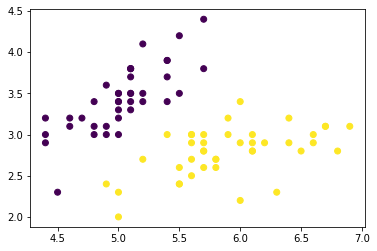

In [12]:
# plot labels and features
import matplotlib.pyplot as plt
plt.scatter(iris_train_features[:,0], iris_train_features[:,1], c=iris_train_labels, cmap='viridis')

In [13]:
# dimensions of train and test sets
print(iris_train_features.shape, iris_train_labels.shape)
print(iris_test_features.shape, iris_test_labels.shape)

(80, 4) (80,)
(20, 4) (20,)


In [14]:
#initialize network
nn = network()
nn.add_layer(6,4,6)
nn.add_layer(4,6,4)
# define the output layer
nn.add_layer(1,4,1)

In [15]:
nn.train(iris_train_features, iris_train_labels,10,0.01)
nn.predict(iris_test_features)
predictions = nn.predict(iris_test_features)
predictions = np.where(np.array(predictions)>= 0.5, 1, 0)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(iris_test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



In [17]:
# sklearn neural network to classify iris dataset
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,4), random_state=1, learning_rate_init=0.01, max_iter = 10)
clf.fit(iris_train_features, iris_train_labels)

from sklearn.metrics import classification_report
print(classification_report(iris_test_labels, clf.predict(iris_test_features)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



/Users/udeshhabaraduwa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train on the Circles dataset

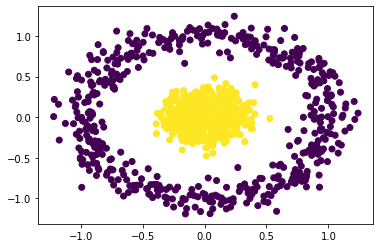

In [18]:
# sklearn make circles dataset
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
# generate dataset
X_circles, y_circles = make_circles(n_samples=1000, noise=0.1, factor=0.2, random_state=1)
# plot dataset
plt.scatter(X_circles[:,0], X_circles[:,1], c=y_circles, cmap='viridis')

In [19]:
# split into training and testing data
from sklearn.model_selection import train_test_split
X_train_circles, X_test_circles, y_train_circles, y_test_circles= train_test_split(X_circles, y_circles, test_size=0.2, random_state=42)


In [20]:
# define network
nn = network()
nn.add_layer(3,2,3)
# define the output layer
nn.add_layer(1,3,1)

In [21]:
# displays the network
nn.display_network()

layer : [2 input Neuron, 2 input Neuron, 2 input Neuron]
node : [-0.28878364 -0.0268412 ]
node : [0.85395699 1.23870221]
node : [-0.35895094  0.71459168]
layer : [3 input Neuron]
node : [ 0.72948524  0.02126069 -1.35575497]


In [22]:
nn.train(X_train_circles, y_train_circles, 1000, 0.01)

In [23]:
nn.display_network()

layer : [2 input Neuron, 2 input Neuron, 2 input Neuron]
node : [-9.70663216  2.05114507]
node : [6.81096497 8.08624113]
node : [-3.10045648  9.91538909]
layer : [3 input Neuron]
node : [ 12.70058648  12.83275286 -14.03204769]


In [24]:
predictions = nn.predict(X_test_circles)
predictions = np.where(np.array(predictions)>= 0.5, 1, 0)
from sklearn.metrics import classification_report
print(classification_report(y_test_circles, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       103

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

